# Netflix Movie Recommender System

Using the [Netflix Movie Dataset from Kaggle](https://www.kaggle.com/netflix-inc/netflix-prize-data) to build a recommender system based on similarity matrixes.



Matheus Schmitz

<a href="https://www.linkedin.com/in/matheusschmitz/"/>LinkedIn</a>

<a href="https://matheus-schmitz.github.io"/>Portfolio</a>

## Google Colab

In [1]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Netflix_Movie_Recommender/")

Mounted at /content/drive


## Imports

In [34]:
# Generic 
import os
from datetime import datetime
import random
from tqdm import tqdm

# Py Data Stack
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# Visualisation
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
%config InlineBackend.print_figure_kwargs = {}
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')

# Scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Scikit Learn
from sklearn.decomposition import TruncatedSVD, PCA, IncrementalPCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Get rid of warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading Data

Kaggle dataset: https://www.kaggle.com/netflix-inc/netflix-prize-data

With such a large dataset, everything line of code will take a while...

In [3]:
# Merging the four txt files with movies and ratings into a single CSV dataset
start = datetime.now()

# Check if the CSV with all movies has already been created, if not, create it
if not os.path.isfile('data/dataset.csv'):
 
    # List the files to be read and merged
    file_list = ['data/combined_data_1.txt',
                 'data/combined_data_2.txt',
                 'data/combined_data_3.txt',
                 'data/combined_data_4.txt']

    # Create file to store the merged result
    dataset = open('data/dataset.csv', mode='w')
    
    # Iterate through the file_list
    for file in tqdm(file_list):
        
        # Open the file
        with open(file) as f:
            
            # Loop through each line in the file
            for line in f:
                
                # Remove the leading/trailing characters from the line (such as \n)
                line = line.strip()
                
                # If a line ends with ":", it's the beginning of the data series for a movie
                if line.endswith(':'):
                    
                    # Set the number before the ":" as the movie ID
                    movie_id = line[:-1]
                
                # The ensuing lines (until another line with ":") are data points for the movie
                else:
                    
                    # The datapoints are comma-separated
                    datapoint = [x for x in line.split(',')]
                    
                    # Add the movie_id to the datapoint
                    datapoint.insert(0, movie_id)
                    
                    # Write the datapoint as a row on the dataset.csv file
                    dataset.write(','.join(datapoint))
                    dataset.write('\n')
    
    # Close the dataset.csv file
    dataset.close()
    
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000613


In [4]:
# Load dataset.csv as a DataFrame
df = pd.read_csv('data/dataset.csv', names=['movie', 'user', 'rating', 'date'], parse_dates=['date'])

# Set the date column to datetime
df.date = pd.to_datetime(df.date)

# Then order the DataFrame according to time, so the the latest 20% of instances can be used as test data
df.sort_values(by='date', inplace=True)

# Result
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


## Exploratory Analysis

In [5]:
# Distribution of the rating column
df.rating.describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [6]:
# Check for missing values
print("No of Nan values in the dataframe: ", sum(df.isnull().any()))

No of Nan values in the dataframe:  0


In [7]:
# Check for duplicates (if same user gave same movie more than one rating )
dup_mask = df.duplicated(['movie', 'user'])
dups = sum(dup_mask)
print("No of duplicate entries in the dataframe: ", dups)

No of duplicate entries in the dataframe:  0


In [8]:
# Basic statistics for movies, users, ratings and dates
print('Count of ratings:', df.shape[0])
print('Unique users:', len(np.unique(df.user)))
print('Unique movies:', len(np.unique(df.movie)))
print('Earliest date:', df.date.min())
print('Latest date:', df.date.max())

Count of ratings: 100480507
Unique users: 480189
Unique movies: 17770
Earliest date: 1999-11-11 00:00:00
Latest date: 2005-12-31 00:00:00


## Train-Test Split

In [9]:
# Setting the earliest 80% of records as train and the lastest 20% as test
# Before creating train and test csvs check if they already exist
if not os.path.isfile('data/dataset_train.csv'):
    df_train = df.iloc[:int(df.shape[0]*0.80)]
    df_train.to_csv('data/dataset_train.csv', index=False)
else:
    df_train = pd.read_csv('data/dataset_train.csv', parse_dates=['date'])

if not os.path.isfile('data/dataset_test.csv'):
    df_test = df.iloc[int(df.shape[0]*0.80):]
    df_test.to_csv('data/dataset_test.csv', index=False)
else:
    df_test = pd.read_csv('data/dataset_test.csv', parse_dates=['date'])

# Then delete the base dataframe to clean up memory
del df

In [102]:
# Reduce data to make the dataset processable on a normal computer
df_train = pd.read_csv('data/dataset_train.csv', parse_dates=['date'])
df_train = df_train[(df_train.user < max(df_train.user)/100) & (df_train.movie < max(df_train.movie)/5)]
print(f'df_train.shape: {df_train.shape}')
df_test = pd.read_csv('data/dataset_test.csv', parse_dates=['date'])
df_test = df_test[(df_test.user < max(df_test.user)/100) & (df_test.movie < max(df_test.movie)/5)]
print(f'df_test.shape: {df_test.shape}')

df_train.shape: (152842, 4)
df_test.shape: (34457, 4)


In [103]:
# Basic statistics for df_train
print('Count of ratings:', df_train.shape[0])
print('Unique users:', len(np.unique(df_train.user)))
print('Unique movies:', len(np.unique(df_train.movie)))
print('Earliest date:', df_train.date.min())
print('Latest date:', df_train.date.max())

Count of ratings: 152842
Unique users: 3815
Unique movies: 3014
Earliest date: 1999-12-31 00:00:00
Latest date: 2005-08-08 00:00:00


In [104]:
# Basic statistics for df_test
print('Count of ratings:', df_test.shape[0])
print('Unique users:', len(np.unique(df_test.user)))
print('Unique movies:', len(np.unique(df_test.movie)))
print('Earliest date:', df_test.date.min())
print('Latest date:', df_test.date.max())

Count of ratings: 34457
Unique users: 2824
Unique movies: 2173
Earliest date: 2005-08-08 00:00:00
Latest date: 2005-12-31 00:00:00


## Exploratory Analysis on Train Data

In [105]:
# Method to swap 0's for {K, M or B}, to clean up the axis
def clean_axis(num, units = 'M'):
    num = float(num)
    if units.lower() == 'k':
        return str(num/10**3) + ' K'
    elif units.lower() == 'm':
        return str(num/10**6) + ' M'
    elif units.lower() == 'b':
        return str(num/10**9) + ' B'

<IPython.core.display.Javascript object>

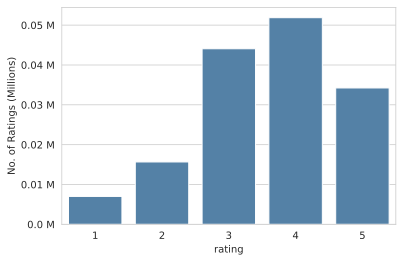

In [106]:
# Plot distribution of ratings
fig, ax = plt.subplots()
sns.countplot(df_train.rating, color='steelblue')
ax.set_yticklabels([clean_axis(tick, 'M') for tick in ax.get_yticks()])
ax.set_ylabel('No. of Ratings (Millions)')
plt.show()

<IPython.core.display.Javascript object>

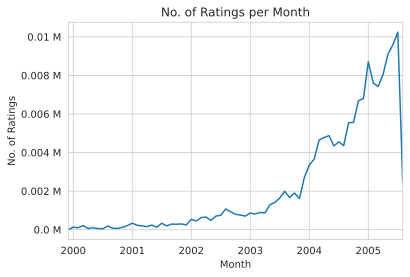

In [107]:
# Plot number of ratings given over time (monthly basis)
fig = plt.figure()
ax = df_train.resample('m', on='date')['rating'].count().plot(kind='line')
ax.set_title('No. of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('No. of Ratings')
ax.set_yticklabels([clean_axis(tick, 'M') for tick in ax.get_yticks()])
plt.show()

### Average Rating per User, per Movie, and Overall

<IPython.core.display.Javascript object>

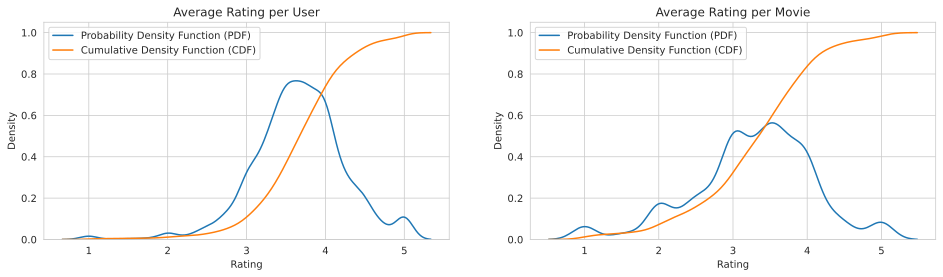

In [108]:
# Calculate average ratings
avg_rating_user = df_train.groupby('user').rating.mean()
avg_rating_movie = df_train.groupby('movie').rating.mean()
avg_rating_overall = df_train.rating.mean()

# Plot
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(0.25))

# Average Rating per User
fig.sca(axes[0])
axes[0].set_title('Average Rating per User')
sns.distplot(avg_rating_user.values, label='Probability Density Function (PDF)', hist=False, ax=axes[0])
sns.distplot(avg_rating_user.values, label='Cumulative Density Function (CDF)', hist=False, ax=axes[0], kde_kws={'cumulative':True})
plt.xlabel('Rating')
plt.legend()

# Average Rating per Movie
fig.sca(axes[1])
axes[1].set_title('Average Rating per Movie')
sns.distplot(avg_rating_movie.values, label='Probability Density Function (PDF)', hist=False, ax=axes[1])
sns.distplot(avg_rating_movie.values, label='Cumulative Density Function (CDF)', hist=False, ax=axes[1], kde_kws={'cumulative':True})
plt.xlabel('Rating')
plt.legend()

plt.show()

In [109]:
print(f'The average rating overall is {avg_rating_overall:.2f}!')

The average rating overall is 3.59!


### Analyse Ratings per User

In [110]:
ratings_per_user = df_train.groupby('user')['rating'].count().sort_values(ascending=False)
ratings_per_user.describe()

count    3815.000000
mean       40.063434
std        58.071202
min         1.000000
25%         7.000000
50%        20.000000
75%        49.000000
max      1081.000000
Name: rating, dtype: float64

<IPython.core.display.Javascript object>

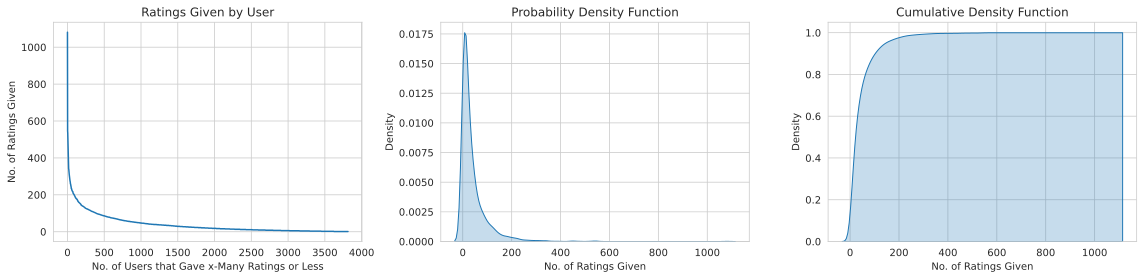

In [111]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=plt.figaspect(0.25))

fig.sca(axes[0])
plt.plot(ratings_per_user.values)
plt.title('Ratings Given by User')
plt.xlabel('No. of Users that Gave x-Many Ratings or Less')
plt.ylabel('No. of Ratings Given')
plt.show()

fig.sca(axes[1])
sns.kdeplot(ratings_per_user, shade=True, ax=axes[1])
plt.xlabel('No. of Ratings Given')
plt.title('Probability Density Function')

fig.sca(axes[2])
sns.kdeplot(ratings_per_user, shade=True, cumulative=True, ax=axes[2])
plt.xlabel('No. of Ratings Given')
plt.title('Cumulative Density Function')

plt.tight_layout()

> This looks veeeeery lopsided... A few movie raters amount for most ratings!
>
> The quantitles are probably quite skewed...

<IPython.core.display.Javascript object>

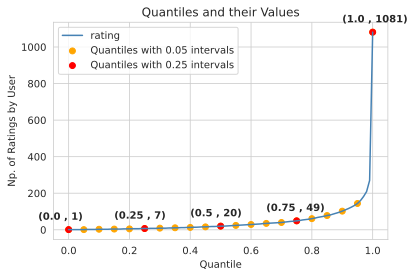

In [112]:
# Extracting the quantiles
quantiles = ratings_per_user.quantile(np.arange(0, 1.01, 0.01), interpolation='higher')

# Plotting the quantils
quantiles.plot(kind='line', color='steelblue')

# Demark the quantiles in increments of 0.05 and 0.25
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label='Quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='red', label='Quantiles with 0.25 intervals')

# Titles, labels, legend
plt.title('Quantiles and their Values')
plt.xlabel('Quantile')
plt.ylabel('Np. of Ratings by User')
plt.legend(loc='best')

# Annotate the 0th, 25th, 50th, 75th and 100th percentiles
for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s=f'({x} , {y})', xy=(x,y), xytext=(x-0.1, y+max(quantiles.values)*0.05), fontweight='bold')

plt.show()

In [113]:
# Checking the deciles
quantiles[::10]

0.0       1
0.1       3
0.2       5
0.3       9
0.4      13
0.5      20
0.6      29
0.7      40
0.8      61
0.9     102
1.0    1081
Name: rating, dtype: int64

**For how many ratings do those top 5% of users account for?**

In [114]:
total_ratings = ratings_per_user.sum()
ratings_by_top_5_pct = ratings_per_user[ratings_per_user.values > list(quantiles)[-6]].sum() # The 6th quantile from back to front means the 95th quantile (100, 99, 98, 97, 96, 95)
print(f'The top 5% movie raters gave {ratings_by_top_5_pct} ratings.')
print(f'That represents {100*ratings_by_top_5_pct/total_ratings:.2f}% of all ratings.')

The top 5% movie raters gave 42677 ratings.
That represents 27.92% of all ratings.


### Analyse Ratings per Movie

In [115]:
# Count ratings obtained by each movie
ratings_per_movie = df_train.groupby('movie')['rating'].count().sort_values(ascending=False)
ratings_per_movie.describe()

count    3014.000000
mean       50.710683
std       140.297730
min         1.000000
25%         2.000000
50%         6.000000
75%        28.000000
max      1585.000000
Name: rating, dtype: float64

<IPython.core.display.Javascript object>

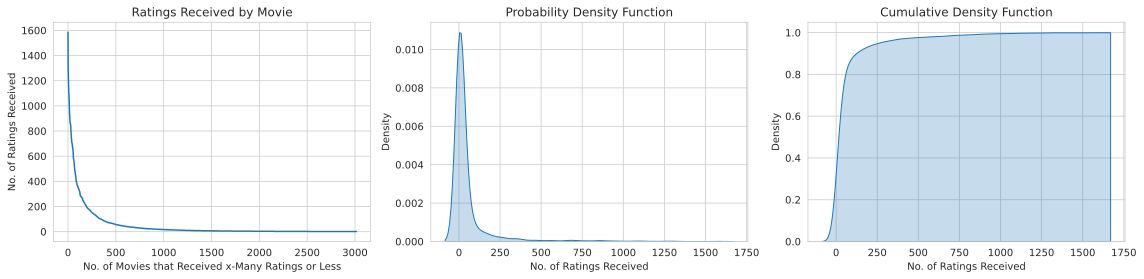

In [116]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=plt.figaspect(0.25))

fig.sca(axes[0])
plt.plot(ratings_per_movie.values)
plt.title('Ratings Received by Movie')
plt.xlabel('No. of Movies that Received x-Many Ratings or Less')
plt.ylabel('No. of Ratings Received')
plt.show()

fig.sca(axes[1])
sns.kdeplot(ratings_per_movie, shade=True)
plt.xlabel('No. of Ratings Received')
plt.title('Probability Density Function')

fig.sca(axes[2])
sns.kdeplot(ratings_per_movie, shade=True, cumulative=True)
plt.xlabel('No. of Ratings Received')
plt.title('Cumulative Density Function')

plt.tight_layout()

> Similar to the number of ratings given by users, the number of ratings received per movie is also very skewed, with a few highly popular movies receiving many ratings while most movies receive much less ratings.

<IPython.core.display.Javascript object>

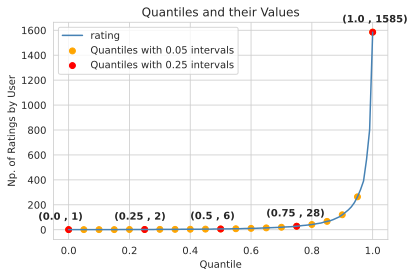

In [117]:
# Extracting the quantiles
quantiles = ratings_per_movie.quantile(np.arange(0, 1.01, 0.01), interpolation='higher')

# Plotting the quantils
quantiles.plot(kind='line', color='steelblue')

# Demark the quantiles in increments of 0.05 and 0.25
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label='Quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='red', label='Quantiles with 0.25 intervals')

# Titles, labels, legend
plt.title('Quantiles and their Values')
plt.xlabel('Quantile')
plt.ylabel('Np. of Ratings by User')
plt.legend(loc='best')

# Annotate the 0th, 25th, 50th, 75th and 100th percentiles
for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s=f'({x} , {y})', xy=(x,y), xytext=(x-0.1, y+max(quantiles.values)*0.05), fontweight='bold')

plt.show()

In [118]:
# Checking the deciles
quantiles[::10]

0.0       1
0.1       1
0.2       2
0.3       3
0.4       4
0.5       6
0.6      11
0.7      20
0.8      42
0.9     120
1.0    1585
Name: rating, dtype: int64

**For how many ratings do those top 5% of movies account for?**

In [119]:
total_ratings = ratings_per_movie.sum()
ratings_by_top_5_pct = ratings_per_movie[ratings_per_movie.values > list(quantiles)[-6]].sum() # The 6th quantile from back to front means the 95th quantile (100, 99, 98, 97, 96, 95)
print(f'The top 5% movies receivede {ratings_by_top_5_pct} ratings.')
print(f'That represents {100*ratings_by_top_5_pct/total_ratings:.2f}% of all ratings.')

The top 5% movies receivede 84595 ratings.
That represents 55.35% of all ratings.


### Analyse Ratings per Day of Week

In [120]:
# Extract day of week from the 'date' column
df_train['day_of_week'] = df_train['date'].dt.day_name()
df_train.tail()

,movie,user,rating,date,day_of_week
80382235,1470,26043,5,2005-08-08,Monday
80382236,1470,17227,4,2005-08-08,Monday
80382244,3151,17837,3,2005-08-08,Monday
80383544,262,79,5,2005-08-08,Monday
80383726,1195,26043,5,2005-08-08,Monday


<IPython.core.display.Javascript object>

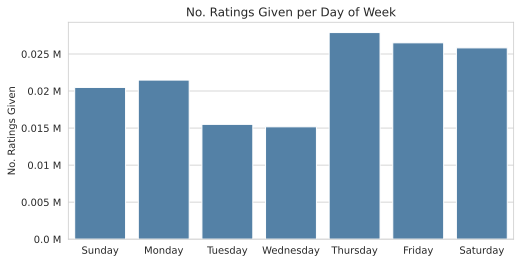

In [121]:
# Plot total ratings given per day of week
fig, ax = plt.subplots(figsize=(8,4))

# Plot
sns.countplot(data=df_train, x='day_of_week', color='steelblue')

# Format Axis
day_sequence = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plt.xticks(range(len(day_sequence)),day_sequence)
ax.set_yticklabels([clean_axis(tick, 'M') for tick in ax.get_yticks()])

# Title and Labels
plt.title('No. Ratings Given per Day of Week')
plt.ylabel('No. Ratings Given')
plt.xlabel('')

plt.show()

<IPython.core.display.Javascript object>

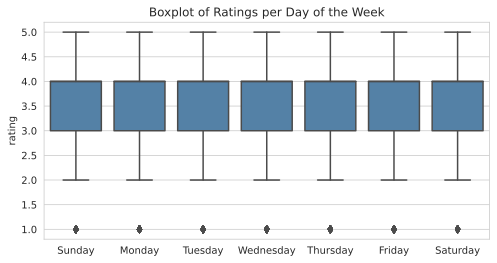

In [122]:
# Boxplot of ratings given per day of the week
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=df_train, x='day_of_week', y='rating', color='steelblue')

# Format Axis
day_sequence = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plt.xticks(range(len(day_sequence)),day_sequence)
plt.title('Boxplot of Ratings per Day of the Week')
plt.xlabel('')
plt.show()

In [123]:
# Average rating given per day of the week
avg_rate_day = df_train.groupby('day_of_week')['rating'].mean()
avg_rate_day

day_of_week
Friday       3.589249
Monday       3.573210
Saturday     3.640955
Sunday       3.573327
Thursday     3.594171
Tuesday      3.597619
Wednesday    3.595231
Name: rating, dtype: float64

<IPython.core.display.Javascript object>

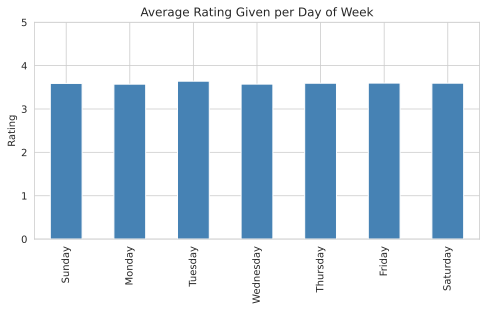

In [124]:
# Plot total ratings given per day of week
fig, ax = plt.subplots(figsize=(8,4))

# Plot
avg_rate_day.plot(kind='bar', color='steelblue')

# Format Axis
day_sequence = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plt.xticks(range(len(day_sequence)),day_sequence)
plt.ylim([0, 5])

# Title and Labels
plt.title('Average Rating Given per Day of Week')
plt.ylabel('Rating')
plt.xlabel('')

plt.show()

> The day of the week doesn't seem to influence the ratings given. That's good, one less thing to worry about!

## Cold Start Problem

> Cold start problem happens when there is no previous data about an item (user, movie, etc...) from which initial recommendations can be made. This happens whenever there is a fresh new user or movie.

**Users | Cold Start Problem**

In [125]:
unique_users_train = df_train.user.unique()
unique_users_test = df_test.user.unique()
unique_users = np.unique(np.append(unique_users_train, unique_users_test))
cold_start_users = np.setdiff1d(unique_users_test, unique_users_train)

print(f'Total users overall: {len(unique_users)}')
print(f'Total users on train: {len(unique_users_train)}')
print(f'Total users on test: {len(unique_users_test)}')
print()
print(f'No. of cold start users: {len(cold_start_users)}')
print(f'Share of cold start users: {100*len(cold_start_users)/len(unique_users):.2f} %')

Total users overall: 4575
Total users on train: 3815
Total users on test: 2824

No. of cold start users: 760
Share of cold start users: 16.61 %


**Movies | Cold Start Problem**

In [126]:
unique_movies_train = df_train.movie.unique()
unique_movies_test = df_test.movie.unique()
unique_movies = np.unique(np.append(unique_movies_train, unique_movies_test))
cold_start_movies = np.setdiff1d(unique_movies_test, unique_movies_train)

print(f'Total movies overall: {len(unique_movies)}')
print(f'Total movies on train: {len(unique_movies_train)}')
print(f'Total movies on test: {len(unique_movies_test)}')
print()
print(f'No. of cold start movies: {len(cold_start_movies)}')
print(f'Share of cold start movies: {100*len(cold_start_movies)/len(unique_movies):.2f} %')

Total movies overall: 3249
Total movies on train: 3014
Total movies on test: 2173

No. of cold start movies: 235
Share of cold start movies: 7.23 %


## Convert Data to Sparse Matrix

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

→ csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])

The matrix will be shaped:

matrix[user, movie] = rating

This way it'll be possible to find similar users by looking at people who gave the same movies the same ratings.

**Train data**

In [128]:
# If the matrix was already created and saved, load it
if os.path.isfile('data/sparse_matrix_train.npz'):
    print('Loading sparse matrix from disk')
    sparse_matrix_train = sparse.load_npz('data/sparse_matrix_train.npz')
# Else create the matrix and save it to disk
else:
    print('Converting DataFrame to sparse matrix')
    sparse_matrix_train = sparse.csr_matrix((df_train.rating.values, #data
                                             (df_train.user.values, df_train.movie.values))) #row_ind, cold_ind
    sparse.save_npz('data/sparse_matrix_train.npz', sparse_matrix_train)

print(f'The matrix shape is {sparse_matrix_train.shape}')

# Obtan density of the matrix (share of non-zero values)
non_zero_values = sparse_matrix_train.getnnz()
M, N = sparse_matrix_train.shape
print(f'Matrix density: {100 * non_zero_values/(M*N):.5f}%')

Converting DataFrame to sparse matrix
The matrix shape is (26494, 3554)
Matrix density: 0.16232%


**Test data**

In [129]:
# If the matrix was already created and saved, load it
if os.path.isfile('data/sparse_matrix_test.npz'):
    print('Loading sparse matrix from disk')
    sparse_matrix_test = sparse.load_npz('data/sparse_matrix_test.npz')
# Else create the matrix and save it to disk
else:
    print('Converting DataFrame to sparse matrix')
    sparse_matrix_test = sparse.csr_matrix((df_test.rating.values, #data
                                             (df_test.user.values, df_test.movie.values))) #row_ind, cold_ind
    sparse.save_npz('data/sparse_matrix_test.npz', sparse_matrix_test)

print(f'The matrix shape is {sparse_matrix_test.shape}')

# Obtan density of the matrix (share of non-zero values)
non_zero_values = sparse_matrix_test.getnnz()
M, N = sparse_matrix_test.shape
print(f'Matrix density: {100 * non_zero_values/(M*N):.5f}%')

Converting DataFrame to sparse matrix
The matrix shape is (26494, 3552)
Matrix density: 0.03661%


## Similarity Matrix Computations

In [130]:
def compute_row_similarity(sparse_matrix, limit_rows=None, update_freq=None):
    num_rows, num_cols = sparse_matrix.shape

    # Get the indexes of non-zero entries for row_x_col
    row_idx, col_idx = sparse_matrix.nonzero()

    # Make a set of row (remove duplicated row indexes fom row_idx)
    row_idx = list(set(row_idx))

    # Time
    time_taken = []
    start = datetime.now()

    # Number of rows to be computed:
    if limit_rows != None:
        print(f'Computing for {limit_rows} rows:')
    else:
        print(f'Computing for all {len(row_idx)} rows:')

    # Lists to store data from iterations
    rows, similars, scores = [], [], []

    # Define number of iteratiosn to run
    num_iters = [limit_rows, len(row_idx)]
    num_iters = min(i for i in num_iters if i is not None)

    # Adjust "None" update_feq
    if update_freq is None:
        update_freq = num_iters

    # Loop through the desired number of iterations
    for row in row_idx[:num_iters]:
        prev = datetime.now()

        # Compute the similarity from the current row versus others
        row_sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        row_sim_idx_highest = row_sim.argsort()[-num_iters:]
        row_sim_scores = row_sim[row_sim_idx_highest]

        # Add row, similars and scores to lists
        rows.extend([row]*num_iters)
        similars.extend(row_sim_idx_highest)
        scores.extend(row_sim_scores)

        # Time taken for 1 iteration
        time_taken.append(datetime.now().timestamp() - prev.timestamp())

        # At every "update_freq" rows print an update
        if len(time_taken)%update_freq == 0:
            print(f'Finished computing the {len(time_taken)}th row, time elapsed {datetime.now()-start}')

    # Once iterated though all rows, convert data to sparse matrix
    # The "shape" parameter will merge rows and columns of same index, resulting in a matrix of row_idx x row_idx
    output = sparse.csr_matrix((scores, (rows, similars)), shape=(num_rows, num_rows)) 

    print()
    print(f'Total time taken: {datetime.now()-start}')
    print(f'Time taken per row: {(datetime.now()-start) / len(time_taken)}')
    return output

### User-User Similarity Matrix (all dimensions)

In [131]:
user_user_sim_matrix = compute_row_similarity(sparse_matrix_train, limit_rows=100, update_freq=20)

Computing for 100 rows:
Finished computing the 20th row, time elapsed 0:00:00.120328
Finished computing the 40th row, time elapsed 0:00:00.239836
Finished computing the 60th row, time elapsed 0:00:00.360004
Finished computing the 80th row, time elapsed 0:00:00.479642
Finished computing the 100th row, time elapsed 0:00:00.601532

Total time taken: 0:00:00.607585
Time taken per row: 0:00:00.006077


In [132]:
print(f'user_user_sim_matrix.shape: {user_user_sim_matrix.shape}')

user_user_sim_matrix.shape: (26494, 26494)


> At this pace it'll never finish computing because there are just wayyy too many dimensions (1 per movie). Let's try dimensionality reduction.

### Dimensionality Reduction

> Unfortunately since the movies and users in df_train and df_test are different, there is no good way of training a dimensionality reductor (eg: TruncatedSVD) and then transforming the test dataset from it, which won't work because the train and test sparse matrixes will be of different shapes (not all users and movies will be in both)

> For now I'll be moving ahead using only the train dataset then.

In [133]:
# If the reduced matrixes were already created and saved, load them
if os.path.isfile('data/sparse_matrix_train_reduced.npz') & os.path.isfile('data/sparse_matrix_test_reduced.npz'):
    print('Loading reduced sparse matrix from disk (train matrix)')
    sparse_matrix_train_reduced = sparse.load_npz('data/sparse_matrix_train_reduced.npz')
    ''' 
    print('Loading reduced sparse matrix from disk (test_matrix)')
    sparse_matrix_test_reduced = sparse.load_npz('data/sparse_matrix_test_reduced.npz')
    '''

# Else reduce the matrixes and save them to disk
else:
    print('Reducing sparse matrix (train)')
    start = datetime.now() 
    DIM_REDUCER = TruncatedSVD(n_components=500, algorithm='randomized', n_iter=5)
    matrix_train_reduced = DIM_REDUCER.fit_transform(sparse_matrix_train) # FIT_TRANSFORM
    sparse_matrix_train_reduced = sparse.csr_matrix(matrix_train_reduced)
    sparse.save_npz('data/sparse_matrix_train_reduced.npz', sparse_matrix_train_reduced)
    print(f'Finished! Time taken: {datetime.now()-start}')
    
    '''
    print()
    print('Reducing sparse matrix (test)')
    start = datetime.now() 
    matrix_test_reduced = DIM_REDUCER.transform(sparse_matrix_test) # ONLY TRANSFORM
    sparse_matrix_test_reduced = sparse.csr_matrix(matrix_test_reduced)
    print(f'Finished! Time taken: {datetime.now()-start}')
    sparse.save_npz('data/sparse_matrix_test_reduced.npz', sparse_matrix_test_reduced)
    '''

print('')
print(f'The reduced train matrix shape is {sparse_matrix_train_reduced.shape}')
#print(f'The reduced test matrix shape is {sparse_matrix_test_reduced.shape}')
print('')

# Obtan density of the matrix (share of non-zero values)
non_zero_values = sparse_matrix_train_reduced.getnnz()
M, N = sparse_matrix_train_reduced.shape
print(f'Train matrix density: {100 * non_zero_values/(M*N):.5f}%')

#non_zero_values = sparse_matrix_test_reduced.getnnz()
#M, N = sparse_matrix_test_reduced.shape
#print(f'Test Matrix density: {100 * non_zero_values/(M*N):.5f}%')

Reducing sparse matrix (train)
Finished! Time taken: 0:00:11.202713

The reduced train matrix shape is (26494, 500)

Train matrix density: 16.02627%


In [134]:
# Function to create number spacing based on their logs
def logspace(start, stop, num):
    return [np.exp(i) for i in np.linspace(np.log(start), np.log(stop), num=num)]

<IPython.core.display.Javascript object>

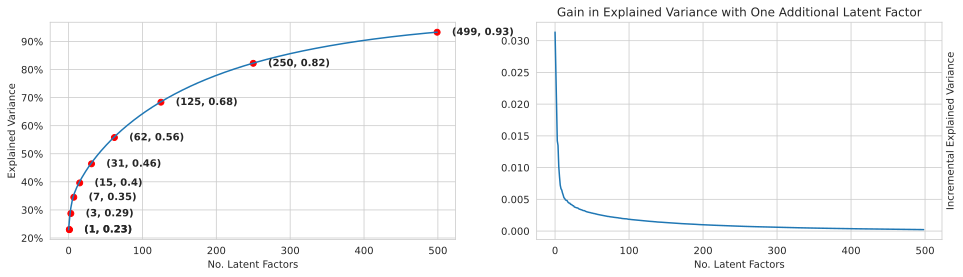

In [135]:
# Get the explained variance ratio
expl_var = np.cumsum(DIM_REDUCER.explained_variance_ratio_)

# Figure, axes
fig, axes = plt.subplots(ncols=2, figsize=(16,4))

# Explained Variance x No. Latent Factors
axes[0].plot(expl_var)
plt.sca(axes[0])
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
axes[0].set_ylabel('Explained Variance')
axes[0].set_xlabel('No. Latent Factors')

# Plot some Latent Factors over the curve
latent_factors = [int(i) for i in logspace(1, 500, 10)]
axes[0].scatter(x=[lf for lf in latent_factors],
                y=expl_var[[lf-1 for lf in latent_factors]],
                c='red')
for lf in latent_factors:
    axes[0].annotate(s = f'({lf}, {np.round(expl_var[lf-1], 2)})',
                     xy = (lf-1, expl_var[lf-1]),
                     xytext = (lf+20, expl_var[lf-1]-0.01),
                     fontweight = 'bold')

# Incremental Explained Variance
incremental_expl_var = [expl_var[lf+1] - expl_var[lf] for lf in range(len(expl_var)-1)]
axes[1].plot(incremental_expl_var)
axes[1].set_title('Gain in Explained Variance with One Additional Latent Factor')
axes[1].set_xlabel('No. Latent Factors')
axes[1].set_ylabel('Incremental Explained Variance')
axes[1].yaxis.set_label_position("right")

plt.show()

### User-User Similarity Matrix (reduced dimensions)

In [136]:
user_user_sim_matrix = compute_row_similarity(sparse_matrix_train_reduced, limit_rows=100, update_freq=20)

Computing for 100 rows:
Finished computing the 20th row, time elapsed 0:00:01.173032
Finished computing the 40th row, time elapsed 0:00:02.338001
Finished computing the 60th row, time elapsed 0:00:03.507799
Finished computing the 80th row, time elapsed 0:00:04.672560
Finished computing the 100th row, time elapsed 0:00:05.851702

Total time taken: 0:00:05.858256
Time taken per row: 0:00:00.058583


In [137]:
print(f'user_user_sim_matrix.shape: {user_user_sim_matrix.shape}')

user_user_sim_matrix.shape: (26494, 26494)


> The shape of the matrix didn't shrink because we haven't reduced the number of users, but rather the number of dimensions along which we compare user similarity.

### Movie-Movie Similarity Matrix

In [138]:
# Pass a transposed sparse_matrix to the compute_row_similarity function to obtain similarity among columns (in this case movies)
movie_movie_sim_matrix = compute_row_similarity(sparse_matrix_train.T, update_freq=100)

Computing for all 3014 rows:
Finished computing the 100th row, time elapsed 0:00:00.893687
Finished computing the 200th row, time elapsed 0:00:01.779199
Finished computing the 300th row, time elapsed 0:00:02.679683
Finished computing the 400th row, time elapsed 0:00:03.599708
Finished computing the 500th row, time elapsed 0:00:04.513895
Finished computing the 600th row, time elapsed 0:00:05.441121
Finished computing the 700th row, time elapsed 0:00:06.313246
Finished computing the 800th row, time elapsed 0:00:07.218897
Finished computing the 900th row, time elapsed 0:00:08.108203
Finished computing the 1000th row, time elapsed 0:00:08.989245
Finished computing the 1100th row, time elapsed 0:00:09.884596
Finished computing the 1200th row, time elapsed 0:00:10.766444
Finished computing the 1300th row, time elapsed 0:00:11.635589
Finished computing the 1400th row, time elapsed 0:00:12.536775
Finished computing the 1500th row, time elapsed 0:00:13.421145
Finished computing the 1600th row, 

In [139]:
print(f'movie_movie_sim_matrix.shape: {movie_movie_sim_matrix.shape}')

movie_movie_sim_matrix.shape: (3554, 3554)


## Finding Similar Movies

In [140]:
# Load the csv with all movie data into a DataFrame
movie_data = pd.read_csv('data/movie_titles.csv', sep=',', header=None, verbose=True,
                         names = ['movie_id', 'year_of_release', 'title'],
                         index_col = 'movie_id', encoding = "ISO-8859-1")

movie_data.head()

Tokenization took: 8.16 ms
Type conversion took: 7.38 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [150]:
def find_similar_movies(movie_id):

    year_of_release = int(movie_data.loc[movie_id][0])
    title = movie_data.loc[movie_id][1]
    num_ratings = sparse_matrix_train[:,movie_id].getnnz()
    avg_rating = df_train[df_train.movie == movie_id].rating.mean()

    print('\033[1m' + 'Movie: ' + '\033[0m' + f'{title}')
    print('\033[1m' + 'Year of Release: ' + '\033[0m' + f'{year_of_release}')
    print('\033[1m' + 'Ratings Received: ' + '\033[0m' + f'{num_ratings}')
    print('\033[1m' + 'Stars: ' + '\033[0m' + f'{avg_rating}')

    # Check the movie-movie sim matrix in the row equivalent to the sought movie
    similarities = movie_movie_sim_matrix[movie_id].toarray().ravel()

    # Sort the array by movie similarity and extract indexes, ignoring the current movie itself
    sim_indices = similarities.argsort()[::-1][1:] 

    # Then display the 10 most similar movies
    return movie_data.loc[sim_indices[:10]]

In [151]:
def plot_similar_movies(movie_id):

    # Get movie title
    title = movie_data.loc[movie_id][1]
    
    # Check the movie-movie sim matrix in the row equivalent to the sought movie
    similarities = movie_movie_sim_matrix[movie_id].toarray().ravel()

    # Sort the array by movie similarity and extract indexes, ignoring the current movie itself
    sim_indices = similarities.argsort()[::-1][1:]

    # Plot
    plt.plot(similarities[sim_indices], label='All Movies')
    plt.plot(similarities[sim_indices[:100]], label='Top 100 Similar Movies')
    plt.title(f"Movies Similar to: {title[:40] + (title[40:] and '..')}", fontsize=16)
    plt.xlabel("K-Nearest Movie", fontsize=14)
    plt.ylabel("Cosine Similarity",fontsize=14)
    plt.legend()
    plt.show()

In [152]:
# Which "Lord of the Rings" movies are in the catalog?
movie_data[movie_data.title.str.contains('Lord of the Rings')]

,year_of_release,title
movie_id,,
13,2003.0,Lord of the Rings: The Return of the King: Ext...
1601,2004.0,J.R.R. Tolkien and the Birth of The Lord of th...
1757,1978.0,The Lord of the Rings
2452,2001.0,Lord of the Rings: The Fellowship of the Ring
3491,2001.0,National Geographic: Beyond the Movie: The Lor...
7057,2002.0,Lord of the Rings: The Two Towers: Extended Ed...
7230,2001.0,The Lord of the Rings: The Fellowship of the R...
8091,2002.0,Lord of the Rings: The Two Towers: Bonus Material
10313,2001.0,Lord of the Rings: The Fellowship of the Ring:...


**Let's see which movies would be recommended for someone who likes "Lord of the Rings"** 

In [153]:
# Let's see which movies would be recommended for someone who likes "Lord of the Rings" 
LOTR_id = movie_data[movie_data.title.str.contains('Lord of the Rings')].index[0]
find_similar_movies(LOTR_id)

Movie: Lord of the Rings: The Return of the King: Extended Edition: Bonus Material
Year of Release: 2003
Ratings Received: 1
Stars: 5.0


,year_of_release,title
movie_id,,
13,2003.0,Lord of the Rings: The Return of the King: Ext...
2032,2004.0,Star Wars Animated Adventures: Ewoks
1360,2003.0,Emmanuelle in Rio
2842,1985.0,The Slugger's Wife
2547,1998.0,Green Legend Ran
547,1992.0,Kuffs
3248,1946.0,Make Mine Music
1452,2001.0,Perfume
1156,2004.0,Being Ron Jeremy


<IPython.core.display.Javascript object>

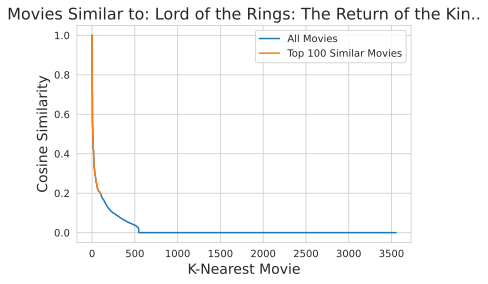

In [154]:
# Let's plot to see how similar (cosine similarity) are those suggestions
plot_similar_movies(LOTR_id)

# End

Matheus Schmitz

<a href="https://www.linkedin.com/in/matheusschmitz/"/>LinkedIn</a>

<a href="https://matheus-schmitz.github.io"/>Portfolio</a>